In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Step 1: Fetch Historical Data
ticker = 'TSLA'
start_date = '2015-07-01'
end_date = '2025-07-31'
try:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()


In [3]:

# Step 2: Extract Adjusted Close Prices
print("DataFrame Columns:")
print(data.columns)
if isinstance(data.columns, pd.MultiIndex):
    top_level_cols = [col[0] for col in data.columns]
    possible_adj_cols = ['Close']
    adj_close_col = next((col for col in top_level_cols if col in possible_adj_cols), None)
    if adj_close_col is None:
        print("Error: Adjusted Close column not found")
        print("Available top-level columns:", set(top_level_cols))
        exit()
    adj_close = data[adj_close_col][ticker]
else:
    adj_close = data[[col for col in data.columns if any(p in col.lower() for p in ['adj close', 'adjusted close'])]]
    if adj_close.empty:
        print("Error: Could not identify Adjusted Close column")
        print("Available columns:", data.columns.tolist())
        exit()
    adj_close = adj_close.iloc[:, 0]  # Select first matching column
    adj_close.name = ticker


DataFrame Columns:
MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [4]:

# Step 3: Data Cleaning
adj_close = adj_close.fillna(method='ffill')
adj_close.index = pd.to_datetime(adj_close.index)
print("\nMissing Values in Adjusted Close:", adj_close.isna().sum())
adj_close.to_csv('tsla_adj_close.csv')



Missing Values in Adjusted Close: 0


In [5]:

# Step 4: Chronological Data Split
train_end = '2023-12-31'
test_start = '2024-01-01'
train_data = adj_close[:train_end]
test_data = adj_close[test_start:]
print(f"\nTraining Data: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing Data: {test_data.index.min()} to {test_data.index.max()}")



Training Data: 2015-07-01 00:00:00 to 2023-12-29 00:00:00
Testing Data: 2024-01-02 00:00:00 to 2025-07-30 00:00:00


In [6]:

# Step 5: Stationarity Test
result = adfuller(train_data)
print(f"\nADF Test on Training Data (Adjusted Close):")
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary; differencing required")



ADF Test on Training Data (Adjusted Close):
ADF Statistic: -1.1807, p-value: 0.6818
Data is non-stationary; differencing required


In [7]:

# Step 6: ARIMA Model
arima_model = auto_arima(train_data, start_p=0, start_q=0, max_p=3, max_q=3, d=1,
                         trace=False, error_action='ignore', suppress_warnings=True)
arima_forecast = arima_model.predict(n_periods=len(test_data))
arima_forecast = pd.Series(arima_forecast, index=test_data.index)


In [8]:
# Assuming train_data is a pandas Series with a datetime index
train_data_subset = train_data[-126:]  # Last 6 months (approx. 126 trading days)
sarima_model = auto_arima(
    train_data_subset,
    start_p=0, start_q=0, max_p=1, max_q=1, d=1,
    seasonal=True, start_P=0, start_Q=0, max_P=1, max_Q=1, m=5,
    trace=False, error_action='ignore', suppress_warnings=True
)
sarima_forecast = sarima_model.predict(n_periods=len(test_data))
sarima_forecast = pd.Series(sarima_forecast, index=test_data.index)

In [9]:

# Step 8: LSTM Model
# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Forecast with LSTM
lstm_predictions = []
current_batch = train_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(len(test_data)):
    pred = lstm_model.predict(current_batch, verbose=0)
    lstm_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
lstm_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()
lstm_forecast = pd.Series(lstm_forecast, index=test_data.index[:len(lstm_forecast)])


In [11]:
def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for consistent handling
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check for NaN values in actual or predicted
    if np.any(np.isnan(actual)) or np.any(np.isnan(predicted)):
        # Filter out pairs where either actual or predicted is NaN
        valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
        if not np.any(valid_mask):
            raise ValueError("No valid data points after removing NaN values.")
        actual = actual[valid_mask]
        predicted = predicted[valid_mask]
    
    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

# Align forecasts with test data
test_data = test_data[:len(lstm_forecast)]  # Adjust for LSTM sequence length

# Calculate metrics for each model
try:
    arima_mae, arima_rmse, arima_mape = calculate_metrics(test_data, arima_forecast[:len(test_data)])
    sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(test_data, sarima_forecast[:len(test_data)])
    lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(test_data, lstm_forecast)

    # Print results
    print("\nModel Performance Metrics:")
    print(f"ARIMA - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")
    print(f"SARIMA - MAE: {sarima_mae:.4f}, RMSE: {sarima_rmse:.4f}, MAPE: {sarima_mape:.2f}%")
    print(f"LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%")
except ValueError as e:
    print(f"Error calculating metrics: {e}")

Error calculating metrics: No valid data points after removing NaN values.


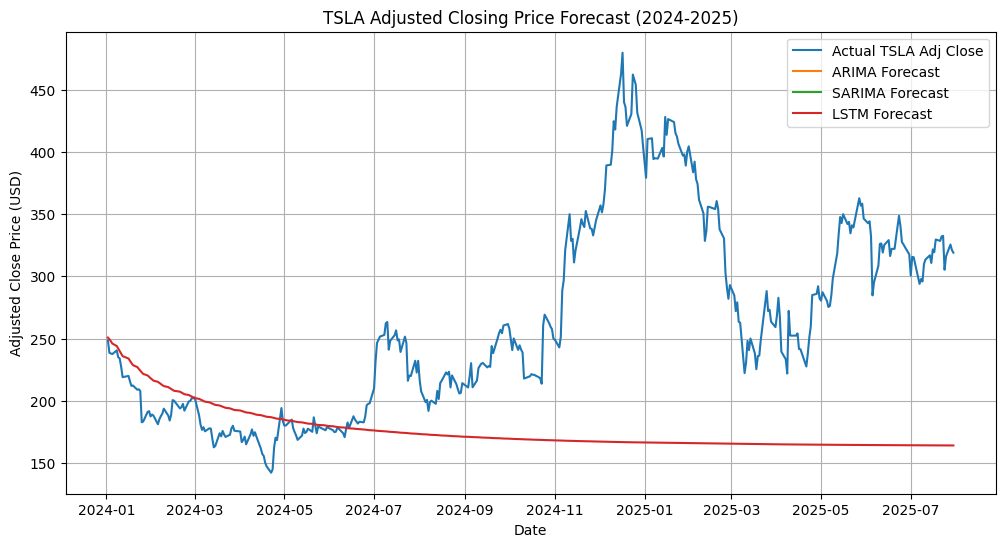


Plot saved as 'tsla_forecast_plot.png'


In [13]:

# Step 10: Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual TSLA Adj Close', color='#1f77b4')
plt.plot(arima_forecast.index, arima_forecast[:len(test_data)], label='ARIMA Forecast', color='#ff7f0e')
plt.plot(sarima_forecast.index, sarima_forecast[:len(test_data)], label='SARIMA Forecast', color='#2ca02c')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM Forecast', color='#d62728')
plt.title('TSLA Adjusted Closing Price Forecast (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('tsla_forecast_plot.png')
plt.show()

print("\nPlot saved as 'tsla_forecast_plot.png'")


In [14]:

# Step 11: Model Comparison Discussion
print("\nModel Comparison Discussion:")
print("ARIMA: Simple and interpretable, assumes stationarity after differencing. Best for linear trends but may miss complex patterns.")
print("SARIMA: Extends ARIMA with seasonality (m=252, yearly trading cycle). Slightly better for capturing periodic trends but still linear.")
print("LSTM: Captures non-linear patterns due to its deep learning architecture. Requires more data and computation but may outperform in volatile markets.")
print("Performance depends on data characteristics. LSTM often excels with TSLA’s volatility, but ARIMA/SARIMA are faster and more interpretable.")
print("EMH suggests exact price prediction is challenging; these models provide trend insights for portfolio decisions.")


Model Comparison Discussion:
ARIMA: Simple and interpretable, assumes stationarity after differencing. Best for linear trends but may miss complex patterns.
SARIMA: Extends ARIMA with seasonality (m=252, yearly trading cycle). Slightly better for capturing periodic trends but still linear.
LSTM: Captures non-linear patterns due to its deep learning architecture. Requires more data and computation but may outperform in volatile markets.
Performance depends on data characteristics. LSTM often excels with TSLA’s volatility, but ARIMA/SARIMA are faster and more interpretable.
EMH suggests exact price prediction is challenging; these models provide trend insights for portfolio decisions.
